## Introduction

Zhenwei Shi, Zhitao Wei, Zhihe Zhao, Zaiyi Liu - *Foundation Model for Quantitative Imaging Analysis in Breast Cancer*

The notebook below gives an exampel to users for fine-tuning based on specific tasks. 



### Setup the environment for the project

In [ ]:
%pip install -r ../requirements.txt

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
sys.path.append("../")

### Load FMBCMRI package and check data 

In [3]:
import fmbcmri
from fmbcmri.lib.utils import pytree

pytree.tree("dataset/DATASET1", max_level=3)

DATASET1
├── Image
│   ├── IS2_d0_C2_100899.nii.gz
│   ├── IS2_d0_C2_102011.nii.gz
│   ├── ...
│   └── IS2_d0_C2_102212.nii.gz
├── Mask
│   ├── IS2_d0_C2_100899.nii.gz
│   ├── IS2_d0_C2_102011.nii.gz
│   ├── ...
│   └── IS2_d0_C2_102212.nii.gz
└── label.csv


### Image data and ROI preview

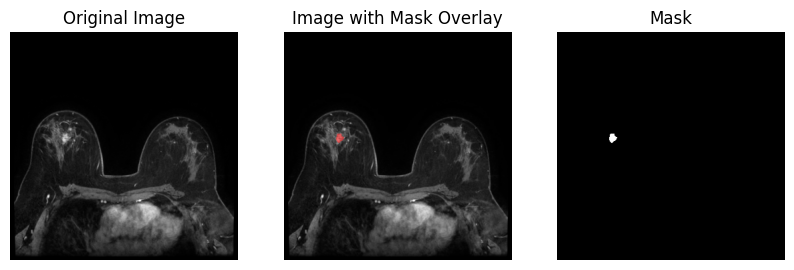

In [4]:
from fmbcmri.lib.utils import read_array, overlay_mask
from matplotlib import pyplot as plt

# Selecting a slice from the dataset
demo_image = read_array("dataset/DATASET1/Image/IS2_d0_C2_100899.nii.gz")[120]
demo_mask = read_array("dataset/DATASET1/Mask/IS2_d0_C2_100899.nii.gz")[120]

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axes[0].imshow(demo_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Combined image and mask
axes[1].imshow(overlay_mask(demo_image, demo_mask, alpha=0.5))
axes[1].set_title('Image with Mask Overlay')
axes[1].axis('off')

# Mask
axes[2].imshow(demo_mask, cmap='gray')
axes[2].set_title('Mask')
axes[2].axis('off')

plt.show()

In [5]:
# check data table
import pandas as pd

pd.read_csv("dataset/DATASET1/label.csv").head()

,Name,PatientID,demo_label
0,IS2_d0_C2_100899.nii.gz,IS2_d0_C2_100899,1
1,IS2_d0_C2_102011.nii.gz,IS2_d0_C2_102011,0
2,IS2_d0_C2_102212.nii.gz,IS2_d0_C2_102212,0
3,IS2_d0_C2_103693.nii.gz,IS2_d0_C2_103693,0
4,IS2_d0_C2_103939.nii.gz,IS2_d0_C2_103939,1


## Fine-tuning the model

### Preprocessing

In [6]:
from fmbcmri.function import preprocessing

# The path that stores your data including `Image` and `Mask`.
input_path = 'dataset/DATASET1'
input_csv = 'dataset/DATASET1/label.csv'
output = 'processed/DATASET1/preprocessed.csv'
preprocessing.preprocessing_main(input_path, input_csv, output)

=> Image dir:  dataset/DATASET1/Image
=> Mask dir:  dataset/DATASET1/Mask
=> Output csv:  processed/DATASET1/preprocessed.csv
=> Label csv:  dataset/DATASET1/label.csv
=> Number of images:  35
=> Number of masks:  35
=> Number of images with mask:  35
=> Number of images with label:  35


100%|██████████| 35/35 [00:49<00:00,  1.42s/it]


### Check the pre-precessing resutls

In [7]:
from fmbcmri.lib.utils import pytree

pytree.tree("processed/DATASET1", max_level=3, max_show=3)

DATASET1
├── all_roi_resize48
│   ├── all_roi_resize48.csv
│   ├── image
│   │   ├── IS2_d0_C2_100899.nii.gz
│   │   ├── IS2_d0_C2_102011.nii.gz
│   │   ├── ...
│   │   └── IS2_d0_C2_102212.nii.gz
│   └── mask
│       ├── IS2_d0_C2_100899.nii.gz
│       ├── IS2_d0_C2_102011.nii.gz
│       ├── ...
│       └── IS2_d0_C2_102212.nii.gz
└── preprocessed.csv


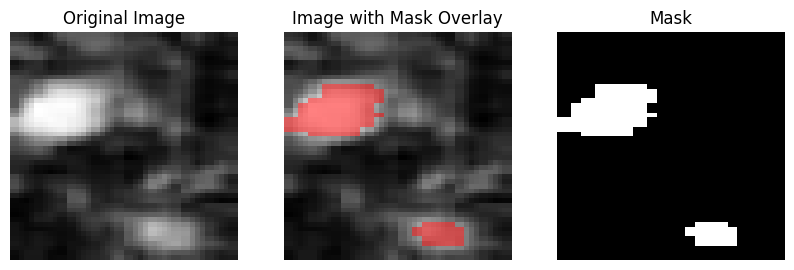

In [8]:
from fmbcmri.lib.utils import read_array, overlay_mask
from matplotlib import pyplot as plt
import numpy as np

# Selecting a slice from the dataset
demo_image = read_array("processed/DATASET1/all_roi_resize48/image/IS2_d0_C2_100899.nii.gz")[23]
demo_mask = read_array("processed/DATASET1/all_roi_resize48/mask/IS2_d0_C2_100899.nii.gz")[23]

# Plotting the images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Original image
axes[0].imshow(demo_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Combined image and mask
axes[1].imshow(overlay_mask(demo_image, demo_mask, alpha=0.5))
axes[1].set_title('Image with Mask Overlay')
axes[1].axis('off')

# Mask
axes[2].imshow(demo_mask, cmap='gray')
axes[2].set_title('Mask')
axes[2].axis('off')

plt.show()

In [9]:
import pandas as pd

to_display_cols = ["Name", "coordX", "coordY",	"coordZ", "roi_start", "roi_end"]

# The ROI details of `processed/DATASET1/preprocessed.csv` is based on the original image.
print("The original image:")
display(pd.read_csv("processed/DATASET1/preprocessed.csv").head(1)[to_display_cols])

# The ROI details of `processed/DATASET1/all_roi_resize48/preprocessed.csv` is based on the resized image.
print("The resized image:")
display(pd.read_csv("processed/DATASET1/all_roi_resize48/all_roi_resize48.csv").head(1)[to_display_cols])

The original image:


,Name,coordX,coordY,coordZ,roi_start,roi_end
0,IS2_d0_C2_115638.nii.gz,84.941135,152.958517,246.401899,"[69, 121, 217]","[111, 179, 273]"


The resized image:


,Name,coordX,coordY,coordZ,roi_start,roi_end
0,IS2_d0_C2_115638.nii.gz,18.263429,26.378596,25.051833,"[0, 0, 0]","[48, 48, 48]"


### Fine-tuning Configs

### Here is a demo provided by Monai

tutorial: https://docs.monai.io/en/latest/config_syntax.html#monai-bundle-configuration

In [10]:
from monai.bundle import ConfigParser
import yaml
import json

demo_config = ConfigParser(yaml.load("""
                                     
# You can use Python code with `$`, but it will run instantly when parsing the config file.
whatever: "$print('Hello World!')" 
                                     
imports:
  - "$import datetime"

in_chans: 1
out_chans: 1
k_size: 3                                     
                                     
conv2d:
    _target_: torch.nn.Conv2d
    in_channels: "@in_chans"      # You can use `@` to refer to the variables defined above.
    out_channels: "@out_chans"
    kernel_size: "@k_size"
                                     
x:
    y: "from x"
    z:
        y: "from z"
        this: "@#y"               # @#A is to use A at the same config structure level
        above: "@##y"             # @##A refers to A at one level above.

now: "$datetime.datetime.now()" # You should import the module first
""", Loader=yaml.SafeLoader)).get_parsed_content()

print(demo_config["conv2d"]) # same as torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
print(demo_config["now"])
print(json.dumps(demo_config["x"], indent=4))

Hello World!
Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
2024-01-03 16:06:22.179109
{
    "y": "from x",
    "z": {
        "y": "from z",
        "this": "from z",
        "above": "from x"
    }
}


### Overview of the config file

In [11]:
config = ConfigParser()
config.read_config('experiments/moco_finetune.yaml')

In [17]:
print(f"""
=> Output directory: "{config["output_root"] + "/" + config["run_name"]}"
=> Batch size: {config["batch_size"]}
=> Number of epochs: {config["epochs"]}
=> Pretrained model: "{config["pretrain"]}"

=> Training dataset: 
    _target_: {config["train_dataset_obj"]["_target_"]}
    csv_path: {config["train_dataset_obj"]["csv_path"]}
    label:    {config["train_dataset_obj"]["label"]}
    ...

=> Validation dataset:
    _target_: {config["val_dataset_obj"]["_target_"]}
    csv_path: {config["val_dataset_obj"]["csv_path"]}
    label:    {config["val_dataset_obj"]["label"]}
    ...
""")


=> Output directory: "finetuning_out/DATASET1"
=> Batch size: 8
=> Number of epochs: 20
=> Pretrained model: "pretrained_checkpoint/breast_MR_checkpoint.pth.tar"

=> Training dataset: 
    _target_: fmbcmri.lib.datasets.PatchDataset
    csv_path: processed/DATASET1/all_roi_resize48/all_roi_resize48.csv
    label:    demo_label
    ...

=> Validation dataset:
    _target_: fmbcmri.lib.datasets.PatchDataset
    csv_path: processed/DATASET1/all_roi_resize48/all_roi_resize48.csv
    label:    demo_label
    ...



## Fine-tuning implementation

In [18]:
from fmbcmri.function.finetuning_main import finetuning_main

yaml_path = 'experiments/moco_finetune.yaml'

finetuning_main(yaml_path)

single process
Use GPU: 0 for training
=> creating model vit_3d_base_patchsize8 of arch None
=> Start loading pretrained weights from pretrained_checkpoint/breast_MR_checkpoint.pth.tar
Loading messages: 
 _IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])
=> Finish loading pretrained weights from pretrained_checkpoint/breast_MR_checkpoint.pth.tar
=> creating optimizer
Param groups information is omitted...
=> changing learning rate to match batch size, lr *= batch_size / 256:  0.1
=> creating train dataloader
=> Train dataset length: 35
=> Val dataset length: 35
finetuning_out/DATASET1/ckpts
 * Test: AUC 0.575 AP 0.720
Epoch: [0][0/4]	Time  0.166 ( 0.166)	Data  0.119 ( 0.119)	Loss 5.6473e-01 (5.6473e-01)	AUC   1.00 (  1.00)	AP   1.00 (  1.00)
 @ Train: Loss 0.75883 AUC 0.500 AP 0.798
finetuning_out/DATASET1/ckpts
 * Test: AUC 0.811 AP 0.887
Epoch: [1][0/4]	Time  0.053 ( 0.053)	Data  0.036 ( 0.036)	Loss 6.8060e-01 (6.8060e-01)	AUC   0.73 (  0.73)	AP   0.81 

### Preview of the output

In [19]:
pytree.tree("finetuning_out/DATASET1", max_level=2)

DATASET1
├── cfgs
│   └── Jan03_16-08-00_sy3090_moco_finetune.yaml
├── ckpts
│   ├── best.pth.tar
│   ├── checkpoint_0004.pth.tar
│   ├── ...
│   └── checkpoint_0009.pth.tar
└── logs
    └── Jan03_16-08-00_sy3090


#### Check the training and validation information. Note that, users should install tensorflow firstly.

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


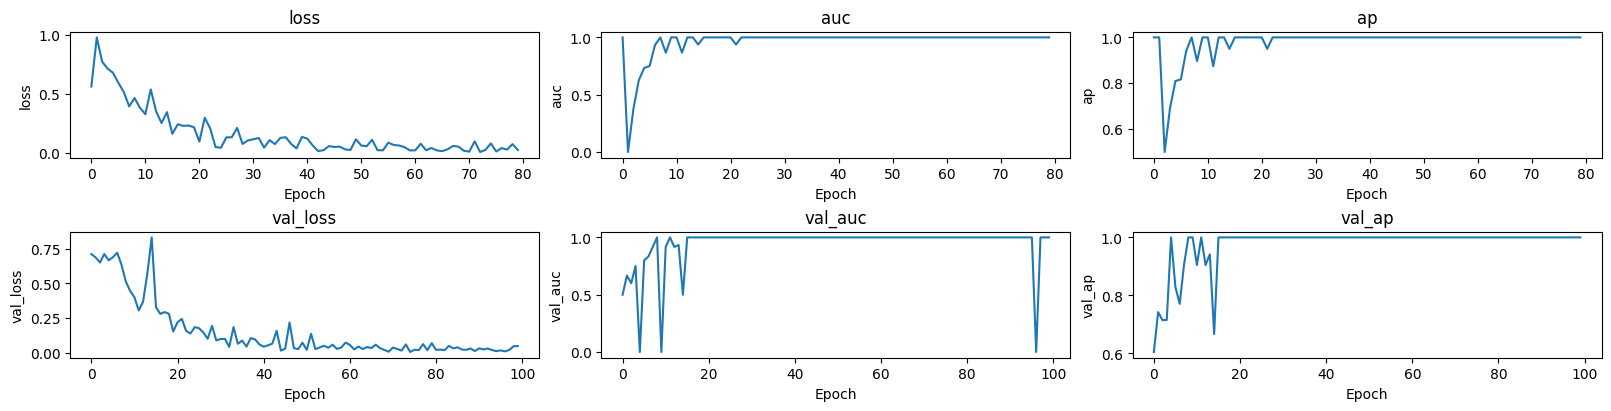

In [20]:
from collections import defaultdict
from pathlib import Path
from tensorflow.python.summary.summary_iterator import summary_iterator

tb_log_path = sorted(Path("finetuning_out/DATASET1/logs").rglob("*tfevents*"))[-1]
metrics = defaultdict(list)
for event in summary_iterator(str(tb_log_path)):
    for value in event.summary.value:
        metrics[value.tag].append(value.simple_value)
# print(metrics.keys()) # ['val_loss', 'val_auc', 'val_ap', 'loss', 'auc', 'ap']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(16, 4), constrained_layout=True)

for i, metric in enumerate(['loss', 'auc', 'ap']):
    axes[0, i].plot(metrics[metric])
    axes[0, i].set_title(metric)
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel(metric)

for i, metric in enumerate(['val_loss', 'val_auc', 'val_ap']):
    axes[1, i].plot(metrics[metric])
    axes[1, i].set_title(metric)
    axes[1, i].set_xlabel('Epoch')
    axes[1, i].set_ylabel(metric)

plt.show()

### Visualization by Grad-CAM

In [21]:
from fmbcmri.lib.utils import read_array, overlay_mask, set_seed
from fmbcmri.function.feature_extraction import load_model
from fmbcmri.third_libs.cam3d.api import run_vit_cam
import torch
import numpy as np
from matplotlib import pyplot as plt

In [22]:
demo_image = read_array("processed/DATASET1/all_roi_resize48/image/IS2_d0_C2_100899.nii.gz")
demo_mask = read_array("processed/DATASET1/all_roi_resize48/mask/IS2_d0_C2_100899.nii.gz")

input_tensor = torch.from_numpy(demo_image)[None, None] # Add batch and channel dimension
input_tensor = (input_tensor - input_tensor.mean()) / input_tensor.std() # Normalize

set_seed(6666)
model = load_model("finetuning_out/DATASET1/ckpts/best.pth.tar").to("cpu")

cam_img = run_vit_cam(model, input_tensor, 1) # 3d

=> Start loading pretrained weights from finetuning_out/DATASET1/ckpts/best.pth.tar
Loading messages: 
 _IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])
=> Finish loading pretrained weights from finetuning_out/DATASET1/ckpts/best.pth.tar


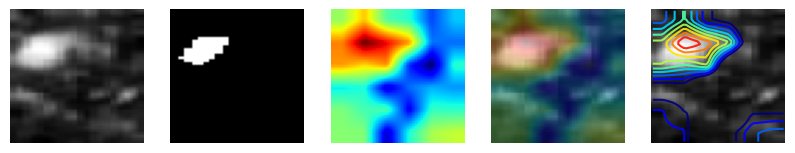

In [23]:
slice_idx = 19
image_slice = demo_image[slice_idx]
mask_slice = demo_mask[slice_idx]
cam_slice = cam_img[slice_idx]


# Plotting the images
fig, axes = plt.subplots(1, 5, figsize=(10, 5))

# Original image
axes[0].imshow(image_slice, cmap='gray')
# axes[0].set_title('Original Image')
axes[0].axis('off')

# Mask
axes[1].imshow(mask_slice, cmap='gray')
# axes[1].set_title('Mask')
axes[1].axis('off')

# Gradcam
axes[2].imshow(cam_slice, cmap="jet")
# axes[2].set_title('Gradcam')
axes[2].axis('off')

# Combined image and gradcam
axes[3].imshow(image_slice, cmap="gray")
axes[3].imshow(cam_slice, cmap="jet", alpha=0.3)
# axes[3].set_title('Combined image and gradcam')
axes[3].axis('off')

# Displaying the contour plot
axes[4].imshow(image_slice, cmap='gray')
contours = axes[4].contour(cam_slice, levels=np.linspace(cam_slice.mean(), cam_slice.max(), num=10), cmap="jet", alpha=0.9)
# axes[4].clabel(contours, inline=True, fontsize=8)
# axes[4].set_title("Contour Plot")
axes[4].axis('off')

plt.show()